# Face Detection
- OpenCV DNN: 25-30 FPS on i7x12

In [110]:
%reload_ext autoreload
%autoreload 2
import os, sys
from os.path import join
import time
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob

import numpy as np
import imutils
import cv2 as cv
import dlib

# append notebook imports folder
sys.path.append(str(Path(os.getcwd()).parent))
from utils import imx

# append vframe imports folder
sys.path.append(str(Path(os.getcwd()).parent.parent/'vframe/'))
from vframe.utils import im_utils, file_utils
from vframe.settings import vframe_cfg as cfg
from vframe.models.bbox import BBox

In [70]:
# get a test image
print(cfg.DIR_TEST_IMAGES)
im_test_list = glob(join(cfg.DIR_TEST_IMAGES, 'faces', '*'))
print('found {} images'.format(len(im_test_list)))
def random_image():
  return np.random.choice(im_test_list)

def perf_times(t, iters):
  te = (time.time() - t) / iters
  fps = iters / (time.time() - t)
  print('time: {:.2f}, {:.2f} FPS'.format(te,fps))

/data_store_hdd/apps/syrianarchive/test/images
found 2 images


# OpenCV DNN Caffe Face Detector

In [71]:
fp_prototxt = join(cfg.DIR_MODELS_CAFFE, 'face_detect', 'opencv_face_detector.prototxt')
fp_model = join(cfg.DIR_MODELS_CAFFE, 'face_detect', 'opencv_face_detector.caffemodel')
dnn_thresh = 0.15
dnn_scale = 1.0
dnn_mean = (104.0, 177.0, 123.0)
dnn_size = (300, 300)

In [72]:
net = cv.dnn.readNetFromCaffe(fp_prototxt, fp_model)

In [73]:
# load the input image and construct an input blob for the image
# by resizing to a fixed 300x300 pixels and then normalizing it
im = cv.imread(random_image())
dst = im.copy()
(h, w) = im.shape[:2]
blob = cv.dnn.blobFromImage(cv.resize(im, dnn_size), dnn_scale, dnn_size, dnn_mean)
iters = 300

import time
st = time.time()
for i in range(iters):
  net.setInput(blob)
  detections = net.forward()
perf_times(st, iters)

time: 0.01, 83.13 FPS


0.99907327
0.9379752


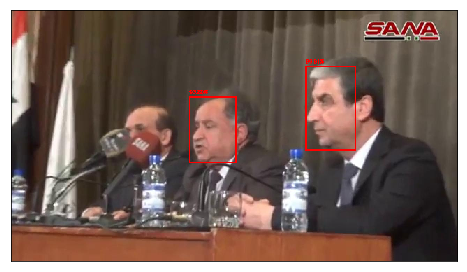

<Figure size 432x288 with 0 Axes>

In [74]:
# plot it
# loop over the detections
for i in range(0, detections.shape[2]):
  # extract the confidence (i.e., probability) associated with the
  # prediction
  confidence = detections[0, 0, i, 2]

  # filter out weak detections by ensuring the `confidence` is
  # greater than the minimum confidence
  if confidence > dnn_thresh:
    print(confidence)
    # compute the (x, y)-coordinates of the bounding box for the
    # object
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")

    # draw the bounding box of the face along with the associated
    # probability
    text = "{:.2f}%".format(confidence * 100)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv.rectangle(dst, (startX, startY), (endX, endY),
        (0, 0, 255), 4)
    cv.putText(dst, text, (startX, y),
    cv.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

imx.pltimg(dst, mode='bgr')

# DLIB HoG Detector
- 7 FPS but during other processing (not using GPU)

In [122]:
#im_dlib = dlib.load_rgb_image(random_image())
im_dlib = cv.cvtColor(im, cv.COLOR_BGR2RGB)
h, w = im_dlib.shape[:2]
im_dlib = cv.resize(im_dlib, (w//2, h//2))
print(im_dlib.shape)

(360, 640, 3)


In [123]:
dlib_hog_predictor = dlib.get_frontal_face_detector()

In [138]:
iters = 10
st = time.time()
for i in range(iters):
  hog_results = dlib_hog_predictor.run(im_dlib, 0)
perf_times(st, iters)

print(hog_results)

time: 0.02, 41.95 FPS
(rectangles[[(237, 141) (309, 213)], [(405, 109) (477, 181)]], [1.3441033517189447, 0.35128833401874937], [1, 1])


In [142]:
if len(hog_results[0]) > 0:
  print(len(hog_results[0]))
  for a, b, c in zip(*hog_results):
    print(b)
    #rect, score, direction = hog_result
    #bbox = BBox.from_dlib_dim(rect, dim)

2
1.3441033517189447
0.35128833401874937


In [133]:
print(scores)

[1.3441033517189447, 0.35128833401874937]


# DLIB CNN Detector
- 7-8 FPS with CUDNN enabled pyramid=1
- 32 FPS with CUDNN enabled pyramid=0
- 72 FPS with CNN batch size 128

In [78]:
import dlib
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
cnn_face_detector = dlib.cnn_face_detection_model_v1(cfg.DIR_MODELS_DLIB_CNN)

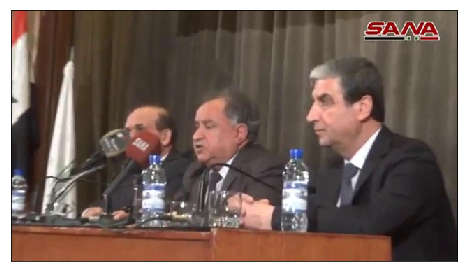

<Figure size 432x288 with 0 Axes>

In [84]:
iters = 100
ims = [im_dlib.copy() for i in range(iters)]

st = time.time()
dets = cnn_face_detector(ims, 0)
perf_times(st, iters)

time: 0.00, 269.49 FPS


In [101]:
st = time.time()
for i in range(iters):
  mmod_rects = cnn_face_detector(im_dlib, 0)
perf_times(st, iters)

time: 0.09, 11.45 FPS


In [120]:
dlib_rect

1.1066441535949707
0.9833391904830933


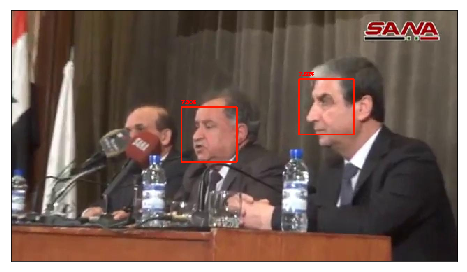

<Figure size 432x288 with 0 Axes>

In [121]:
from vframe.models.bbox import BBox
dim = im_dlib.shape[:2][::-1]
dim_dst = im.shape[:2][::-1]
dst = im.copy()

for mmod_rect in mmod_rects:
  bbox = BBox.from_dlib_dim(mmod_rect.rect, dim)
  x1, y1, x2, y2 = bbox.to_dim(dim_dst).as_xyxy()
  print(mmod_rect.confidence)

  # draw the bounding box of the face along with the associated
  # probability
  text = "{:.2f}%".format(confidence * 100)
  txt_y = y1 - 10 if y1 - 10 > 10 else y1 + 10
  cv.rectangle(dst, (x1, y1), (x2, y2),
      (0, 25, 255), 4)
  cv.putText(dst, text, (x1, txt_y),
  cv.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

imx.pltimg(dst, mode='bgr')

In [37]:
for det in dets:
  bbox = BBox.from_dlib_rect

[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
